In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.stem import PorterStemmer
from scipy.io import loadmat

# Exercise 6.1: Support Vector Machines (dimension-2, power-various, category-2, regularised)
---

In addition to logistic regression and neural networks (which I am currently seeing as a natural extension to logistic regression anyway), a further classification algorithm is given by the method of Support Vector Machines (SVM). Currently (2020/04/10) I'm not sure what the pros and cons of the various systems are, and I've not gone back to review any of Andrew's SVM videos or notes, but I don't remember there being much detail in the course in terms of how this method actually works anyway. This exercise is also not very illustrative, as the main code is given to us and we simply have to implement it in different ways. It doesn't help further my understanding. All I can say is that the SVM approach appears to be able to fit boundary surfaces in order to separate data categories, but we don't see anything in the method that is easily identifiable as a cost function which is being minimised, nor do we see any clear description of exactly what the parameters that we find are relating to. The best we get is just an overview of what the SVM method can provide, at first for various 2D data, and later on for 1899D data. Let's begin by having a look at the first set of 2D data, which, like the first set of 2D data in the logistic regression work of exercise-2, are separable by a flat boundary surface:

In [4]:
d1 = loadmat('ex6/ex6data1.mat')
d1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [21]:
d1_X = d1['X']
d1_X.shape

(51, 2)

In [22]:
d1_y = d1['y']
d1_y.shape

(51, 1)

In [226]:
del(d1)

In [23]:
d1_y_idx0 = np.where(d1_y == 0)[0]
d1_y_idx1 = np.where(d1_y == 1)[0]

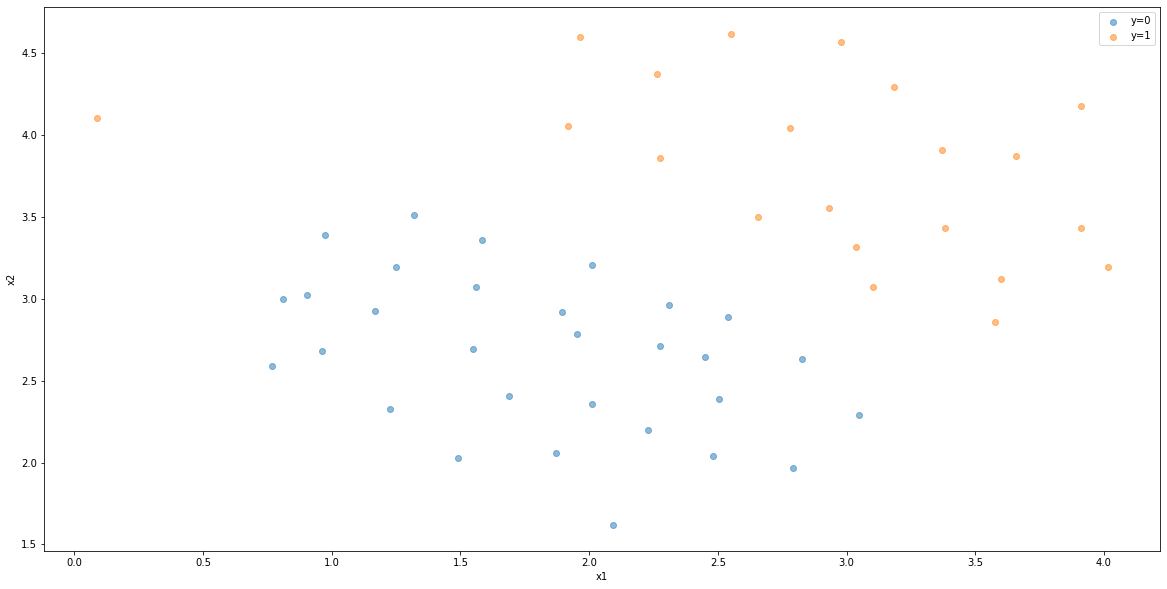

In [24]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], color='C1', alpha=0.5)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['y=0', 'y=1'])
plt.show()

---

Let's make a function to include an offset term via the dummy feature $x_0 = 1$:

In [27]:
def add_ones(X):
    return(np.append(np.ones([X.shape[0],1]), X, axis=1))

---

Now define the SVM training function. Note that the following code is a hacked version of Andrew's Octave code, where I've transposed certain things and switched the indices accordingly. I don't understand what the code is actually doing though, I just made it work and ensured that it gives similar output to that seen in the exercise PDF.

The C parameter is like an inverse regularisation parameter from other methods (i.e. like $1/\lambda$), in that:
- smaller C (bigger $\lambda$) means more regularisation (less prone to overfitting)
- bigger C (smaller $\lambda$) means less regularisation (more prone to overfitting)

In [67]:
# Note that this just returns the value of the Gaussian curve e^((-x^2) / (2 sigma^2)), with x here
# being the distance between two points in parameter space, taking into account all dimensions

def kern_gauss(
    coords1,
    coords2,
    sigma,
):

    val = np.exp(
          (-1 / (2 * np.power(sigma, 2))) \
        * np.sum(np.power(np.array(coords1) - np.array(coords2), 2))
    )

    return(val)

In [68]:
kern_gauss([1,2,1], [0,4,-1], 2)
# 0.32465246735834974

0.32465246735834974

In [111]:
def get_svm(
    X,
    y,
    C,
    kern_func='kern_lin',
    tol=1e-3,
    passes_num_max=5,
    sigma=0.1,
):

    exs_num, feats_num = np.shape(X)

    y = np.transpose(y).astype(int)[0]
    y[np.where(y == 0)] = -1 # Rather than having category labels 0 and 1, we map to -1 and +1. I don't know what the benefit is.

    alphas = np.zeros(exs_num)
    E = np.zeros(exs_num)
    b = 0
    L = 0
    H = 0
    dots = 12
    passes_num = 0
    eta = 0

    if   (kern_func == 'kern_lin'):
        K = np.dot(X, np.transpose(X))
    elif (kern_func == 'kern_gauss'):
        K = np.zeros([exs_num, exs_num])
        for i in range(exs_num):
            for j in range(exs_num):
                K[i][j] = kern_gauss(
                    X[i],
                    X[j],
                    sigma,
                )

    while (passes_num < passes_num_max):

        alphas_changed_num = 0

        for i in range(exs_num):

            E[i] = b - y[i] + np.sum(alphas * y * K[i])

            if ( (y[i] * E[i] < -tol) and (alphas[i] < C) ) \
            or ( (y[i] * E[i] >  tol) and (alphas[i] > 0) ):

                j = i
                while (j == i):
                    j = np.random.randint(exs_num)

                E[j] = b - y[j] + np.sum(alphas * y * K[j])

                if (y[i] == y[j]):
                    L = np.max([0, alphas[j] + alphas[i] - C])
                    H = np.min([C, alphas[j] + alphas[i]])
                else:
                    L = np.max([0, alphas[j] - alphas[i]])
                    H = np.min([C, alphas[j] - alphas[i] + C])

                if (L == H):
                    continue

                eta = 2 * K[i][j] - K[i][i] - K[j][j]

                if (eta >= 0):
                    continue

                alphas_i_old = alphas[i]
                alphas_j_old = alphas[j]

                alphas[j] -= (y[j] * (E[i] - E[j])) / eta
                alphas[j] = np.min([H, alphas[j]])
                alphas[j] = np.max([L, alphas[j]])

                if (abs(alphas[j] - alphas_j_old) < tol):
                    alphas[j] = alphas_j_old
                    continue

                alphas[i] += y[i] * y[j] * (alphas_j_old - alphas[j])

                alphas_changed_num += 1

                b1 = \
                      b \
                    - E[i] \
                    - y[i] * (alphas[i] - alphas_i_old) * K[i][j] \
                    - y[j] * (alphas[j] - alphas_j_old) * K[i][j]
                b2 = \
                      b \
                    - E[j] \
                    - y[i] * (alphas[i] - alphas_i_old) * K[i][j] \
                    - y[j] * (alphas[j] - alphas_j_old) * K[i][i]

                if   ( (0 < alphas[i]) and (alphas[i] < C) ):
                    b = b1
                elif ( (0 < alphas[j]) and (alphas[j] < C) ):
                    b = b2
                else:
                    b = (b1 + b2) / 2

        if (alphas_changed_num == 0):
            passes_num += 1
        else:
            passes_num = 0

        dots += 1

        if (dots > 78):
            dots = 0

    exs_idxs_alphas_gt0 = np.where(alphas > 0)[0]

    return(
        X[exs_idxs_alphas_gt0],
        y[exs_idxs_alphas_gt0],
        alphas[exs_idxs_alphas_gt0],
        np.dot(np.transpose(X), np.transpose([alphas * y])),
        b,
    )

The following function was made by inspecting Andrew's ``svmPredict.m`` Octave function and using The Force a bit, can't say I understand exactly what's going on here, but it looked like he was taking the Gaussian kernal values of a particular point in the meshgrid with all the points in the SVM model output, each multiplied by their model y-values (which are either -1 or +1) and their model alpha values, then summed and compared to zero in order to provide the final category label for that meshgrid point. This could probably be implemented a bit better with some further consideration, but I'm actually surprised it worked at all to give the expected boundary for this part of the exercises, given that I was simply hacking my way through here. Win.

In [39]:
# def get_boundary_surface(
#     x1s,
#     x2s,
#     sigma,
#     svm,
# ):

#     boundary_surface = np.zeros([len(x1s), len(x2s)])

#     for x1s_idx,x1 in enumerate(x1s):
#         for x2s_idx,x2 in enumerate(x2s):
#             p = np.sum([
#                   kern_gauss(
#                       [x1,x2],
#                       svm[0][exs_idx],
#                       sigma,
#                   ) \
#                 * svm[1][exs_idx] \
#                 * svm[2][exs_idx]
#                 for exs_idx in range(svm[1].shape[0])
#             ])
#             boundary_surface[x1s_idx][x2s_idx] = 1 if (p >= 0) else 0

#     return(boundary_surface)

In [46]:
def get_boundary_surface(
    X,
    sigma,
    svm,
):

    boundary_surface = np.zeros(X.shape[0])

    for X_exs_idx in range(X.shape[0]):
        p = np.sum([
              kern_gauss(
                  X[X_exs_idx],
                  svm[0][svm_exs_idx],
                  sigma,
              ) \
            * svm[1][svm_exs_idx] \
            * svm[2][svm_exs_idx]
            for svm_exs_idx in range(svm[1].shape[0])
        ])
#         boundary_surface[X_exs_idx] = 1 if (p >= 0) else 0 # This gives the label of the point in data-space, like taking the rounded sigmoid value in linear regression
        boundary_surface[X_exs_idx] = p

    return(boundary_surface)

---

Now run the SVM function on the given data using the "_linear kernel_" (again, I'm really not sure of the details here). Note that the parts of the SVM output that we use to obtain the boundary surface values, from which the $z=0$ contour is then given, are formed into a vector that is then dotted with the input data. This is exactly what we do in forming hypothesis values in linear and logistic regression, as it is understood that what we are dotting the data with is the optimum parameter vector $\overrightarrow{\theta}$. This gives us some insight into what these parts of the SVM output actually mean.

Try the following with C=1 (high regularisation, low overfitting) and C=100 (low regularisation, high overfitting), and notice what happens with the outlier in each case:

In [112]:
d1_svm = get_svm(
    d1_X,
    d1_y,
    1,
    kern_func='kern_lin',
    passes_num_max=20,
)

In [221]:
d1_X1_range = max(d1_X[:,0]) - min(d1_X[:,0])
d1_Xfit1_lower = min(d1_X[:,0]) - (d1_X1_range * 0.0)
d1_Xfit1_upper = max(d1_X[:,0]) + (d1_X1_range * 0.0)

d1_X2_range = max(d1_X[:,1]) - min(d1_X[:,1])
d1_Xfit2_lower = min(d1_X[:,1]) - (d1_X2_range * 0.0)
d1_Xfit2_upper = max(d1_X[:,1]) + (d1_X2_range * 0.0)

d1_Xfit1 = np.linspace(d1_Xfit1_lower, d1_Xfit1_upper, 100)
d1_Xfit2 = np.linspace(d1_Xfit2_lower, d1_Xfit2_upper, 100)

# Note that the meshgrids, and everything that follows from them, are in [x2,x1] order, not [x1,x2]. Dunno why that is, counterintuitive.

d1_Xfit1_meshgrid, d1_Xfit2_meshgrid = np.meshgrid(d1_Xfit1, d1_Xfit2)

d1_Xfit = np.transpose([d1_Xfit1_meshgrid.flatten(), d1_Xfit2_meshgrid.flatten()])
d1_Xfit_ones = add_ones(d1_Xfit)

d1_hfit = np.dot(d1_Xfit_ones, np.transpose(np.append(d1_svm[4], d1_svm[3])))
d1_hfit_meshgrid = np.reshape(d1_hfit, [d1_Xfit2.shape[0], d1_Xfit1.shape[0]])

# d1_Xfit2_at_z0 = - (d1_svm[4] + d1_Xfit1 * d1_svm[3][0]) / d1_svm[3][1]

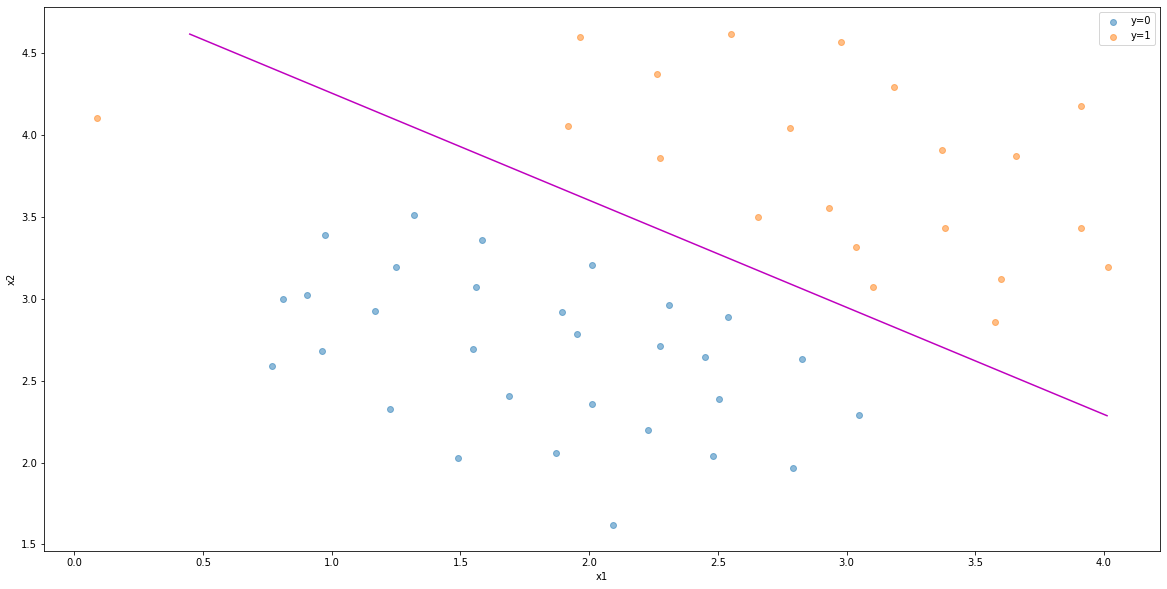

In [222]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X[d1_y_idx0,0], d1_X[d1_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d1_X[d1_y_idx1,0], d1_X[d1_y_idx1,1], color='C1', alpha=0.5)
# ax.plot(d1_Xfit1, d1_Xfit2_at_z0, '-', color='m')
ax.contour(d1_Xfit1_meshgrid, d1_Xfit2_meshgrid, d1_hfit_meshgrid, [0], colors=['m'])
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

Now for some 2D data that can't be separated by a flat boundary surface. In this case we must use the "_Gaussian kernel_". The data are as follows:

In [30]:
d2 = loadmat('ex6/ex6data2.mat')
d2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [31]:
d2_X = d2['X']
d2_X.shape

(863, 2)

In [32]:
d2_y = d2['y']
d2_y.shape

(863, 1)

In [227]:
del(d2)

In [33]:
d2_y_idx0 = np.where(d2_y == 0)[0]
d2_y_idx1 = np.where(d2_y == 1)[0]

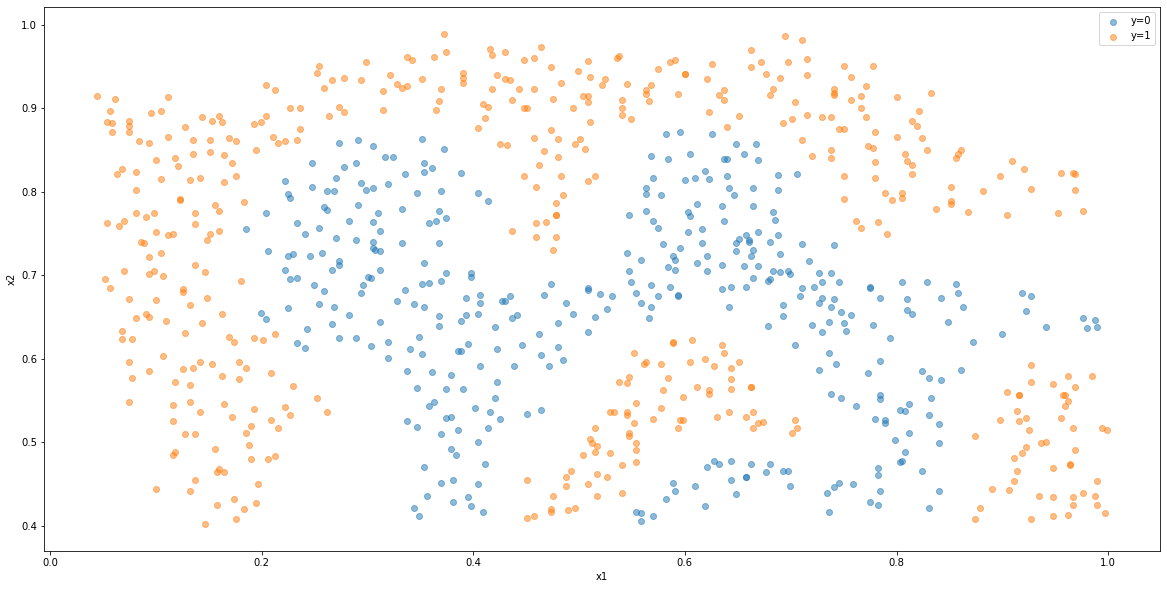

In [35]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], color='C1', alpha=0.5)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['y=0', 'y=1'])
plt.show()

---

Just according to Andrew's instruction, we use C=1 and $\sigma$=0.1 in calling the SVM function. Note that, unlike the flat boundary surface case above, we use more of the model output in obtaining the boundary surface values here:

In [115]:
d2_svm = get_svm(
    d2_X,
    d2_y,
    1,
    kern_func='kern_gauss',
    sigma=0.1,
)

In [116]:
d2_X1_range = max(d2_X[:,0]) - min(d2_X[:,0])
d2_Xfit1_lower = min(d2_X[:,0]) - (d2_X1_range * 0.0)
d2_Xfit1_upper = max(d2_X[:,0]) + (d2_X1_range * 0.0)

d2_X2_range = max(d2_X[:,1]) - min(d2_X[:,1])
d2_Xfit2_lower = min(d2_X[:,1]) - (d2_X2_range * 0.0)
d2_Xfit2_upper = max(d2_X[:,1]) + (d2_X2_range * 0.0)

d2_Xfit1 = np.linspace(d2_Xfit1_lower, d2_Xfit1_upper, 100)
d2_Xfit2 = np.linspace(d2_Xfit2_lower, d2_Xfit2_upper, 100)

# Note that the meshgrids, and everything that follows from them, are in [x2,x1] order, not [x1,x2]. Dunno why that is, counterintuitive.

d2_Xfit1_meshgrid, d2_Xfit2_meshgrid = np.meshgrid(d2_Xfit1, d2_Xfit2)

d2_Xfit = np.transpose([d2_Xfit1_meshgrid.flatten(), d2_Xfit2_meshgrid.flatten()])

d2_hfit = get_boundary_surface(d2_Xfit, 0.1, d2_svm)
d2_hfit_meshgrid = np.reshape(d2_hfit, [d2_Xfit2.shape[0], d2_Xfit1.shape[0]])

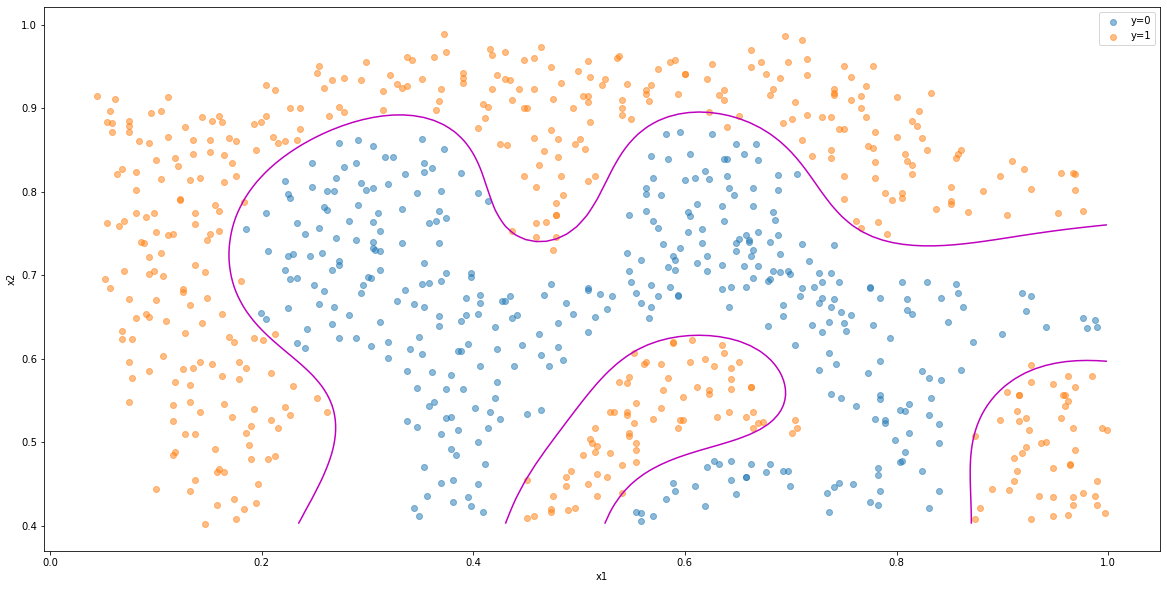

In [117]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d2_X[d2_y_idx0,0], d2_X[d2_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d2_X[d2_y_idx1,0], d2_X[d2_y_idx1,1], color='C1', alpha=0.5)
ax.contour(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, [0], colors=['m'])
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

For our third and final 2D example, unlike in the previous examples where we simply stated C and $\sigma$ values (I guess from Andrew's testing), now we do an actual scan of these values to find those that give the lowest cost with respect to a cross-validation set, and use those to perform the actual run. Like the last example, this is also given the Gaussian kernel treatment, so providing a curved boundary surface. First just observe the data:

In [47]:
d3 = loadmat('ex6/ex6data3.mat')
d3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

In [49]:
d3_X = d3['X']
d3_X.shape

(211, 2)

In [50]:
d3_y = d3['y']
d3_y.shape

(211, 1)

In [53]:
d3_Xval = d3['Xval']
d3_Xval.shape

(200, 2)

In [54]:
d3_yval = d3['yval']
d3_yval.shape

(200, 1)

In [228]:
del(d3)

In [51]:
d3_y_idx0 = np.where(d3_y == 0)[0]
d3_y_idx1 = np.where(d3_y == 1)[0]

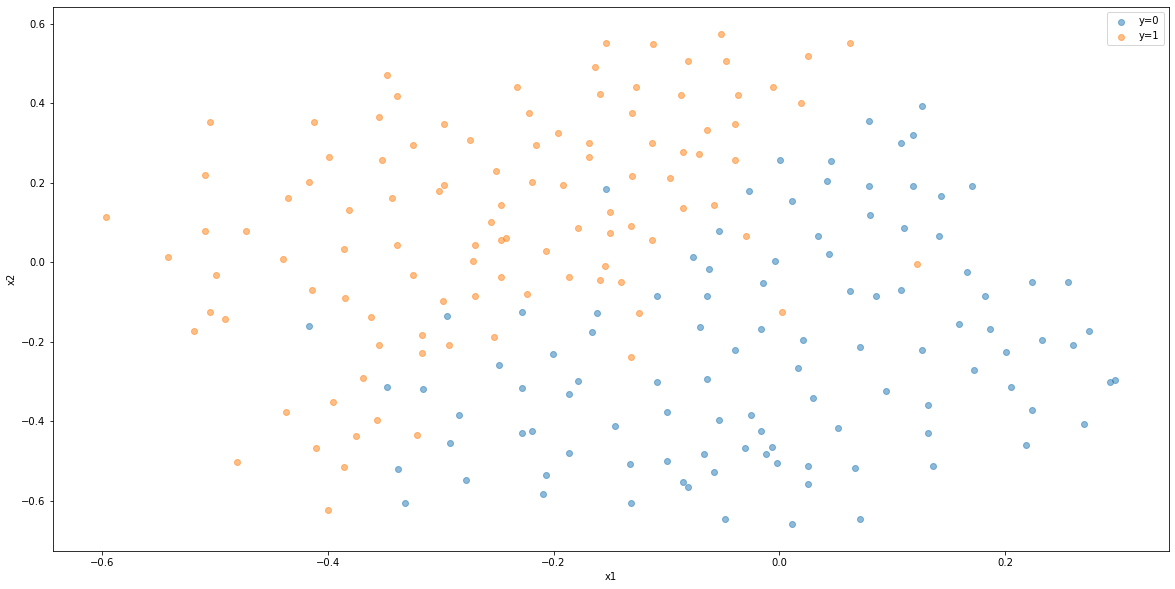

In [52]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d3_X[d3_y_idx0,0], d3_X[d3_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d3_X[d3_y_idx1,0], d3_X[d3_y_idx1,1], color='C1', alpha=0.5)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['y=0', 'y=1'])
plt.show()

---

Now run the SVM function for various C and $\sigma$ values, both in the same range, and define a cost just given by a count of the number of incorrect classifications for each pair of settings:

In [57]:
trials = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
costs = np.zeros([len(trials),len(trials)])

for Cs_idx,C in enumerate(trials):

    for sigmas_idx,sigma in enumerate(trials):

        d3_svm = get_svm(
            d3_X,
            d3_y,
            C,
            kern_func='kern_gauss',
            sigma=sigma,
        )

        for Xval_exs_idx in range(d3_Xval.shape[0]):

            p = np.sum([
                  kern_gauss(
                      d3_Xval[Xval_exs_idx],
                      d3_svm[0][svm_exs_idx],
                      sigma,
                  ) \
                * d3_svm[1][svm_exs_idx] \
                * d3_svm[2][svm_exs_idx]
                for svm_exs_idx in range(d3_svm[1].shape[0])
            ])
            prediction = 1 if (p >= 0) else 0

            if (prediction != d3_yval[Xval_exs_idx,0]):
                costs[Cs_idx][sigmas_idx] += 1

In [58]:
costs

array([[16., 12.,  9., 29., 36., 36., 37., 36.],
       [16., 12.,  9., 28., 36., 36., 37., 37.],
       [16., 12.,  9., 16., 34., 37., 36., 36.],
       [16., 12.,  7., 13., 20., 36., 37., 36.],
       [16., 13.,  6., 14., 15., 32., 37., 36.],
       [16., 16.,  7., 15., 20., 19., 36., 37.],
       [16., 16., 14., 14., 19., 18., 33., 37.],
       [16., 16., 12., 14., 18., 13., 18., 36.]])

In [59]:
np.min(costs)

6.0

In [61]:
costs_idx_min = np.where(costs == np.min(costs))
costs_idx_min

(array([4]), array([2]))

---

Run the SVM function using the optimum settings found by the above experimentation, and show the output as usual:

In [78]:
d3_svm = get_svm(
    d3_X,
    d3_y,
    trials[costs_idx_min[0][0]],
    kern_func='kern_gauss',
    sigma=trials[costs_idx_min[1][0]],
)

In [79]:
d3_X1_range = max(d3_X[:,0]) - min(d3_X[:,0])
d3_Xfit1_lower = min(d3_X[:,0]) - (d3_X1_range * 0.0)
d3_Xfit1_upper = max(d3_X[:,0]) + (d3_X1_range * 0.0)

d3_X2_range = max(d3_X[:,1]) - min(d3_X[:,1])
d3_Xfit2_lower = min(d3_X[:,1]) - (d3_X2_range * 0.0)
d3_Xfit2_upper = max(d3_X[:,1]) + (d3_X2_range * 0.0)

d3_Xfit1 = np.linspace(d3_Xfit1_lower, d3_Xfit1_upper, 100)
d3_Xfit2 = np.linspace(d3_Xfit2_lower, d3_Xfit2_upper, 100)

# Note that the meshgrids, and everything that follows from them, are in [x2,x1] order, not [x1,x2]. Dunno why that is, counterintuitive.

d3_Xfit1_meshgrid, d3_Xfit2_meshgrid = np.meshgrid(d3_Xfit1, d3_Xfit2)

d3_Xfit = np.transpose([d3_Xfit1_meshgrid.flatten(), d3_Xfit2_meshgrid.flatten()])

d3_hfit = get_boundary_surface(d3_Xfit, 0.1, d3_svm)
d3_hfit_meshgrid = np.reshape(d3_hfit, [d3_Xfit2.shape[0], d3_Xfit1.shape[0]])

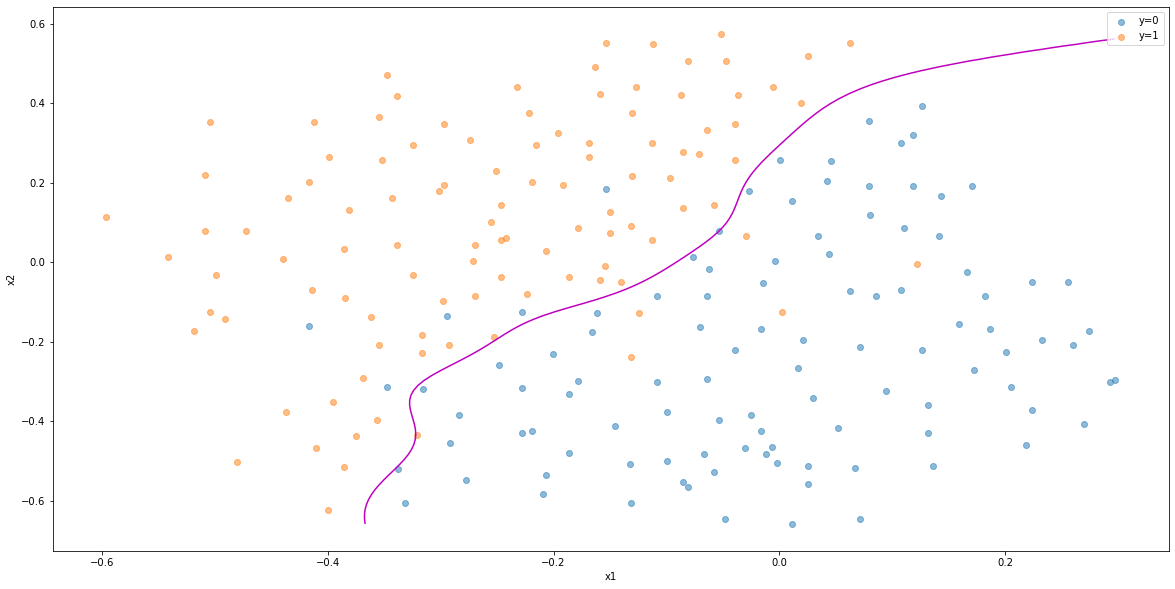

In [80]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d3_X[d3_y_idx0,0], d3_X[d3_y_idx0,1], color='C0', alpha=0.5)
ax.scatter(d3_X[d3_y_idx1,0], d3_X[d3_y_idx1,1], color='C1', alpha=0.5)
ax.contour(d3_Xfit1_meshgrid, d3_Xfit2_meshgrid, d3_hfit_meshgrid, [0], colors=['m'])
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['y=0', 'y=1']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

# Exercise 6.2: Support Vector Machines (dimension-1899, power-1, category-2, regularised)
---

We now look at applying the SVM method to some higher dimensional data. All data sets used up to now, throughout all exercises, have had some continuous range of possible values in all dimensions. Sometimes these have been limited ranges, such as the greyscale values for each pixel in the MNIST handwritten digit images of exercises 3 and 4, but continuous within those ranges nonetheless. Here, though, we use data which are binary in each dimension, which just encodes whether or not a given dimension is active for a given example data point. The data are a set of emails, each then manipulated from the raw text with some adjustments, such as converting all to lowercase and stripping certain characters, and finally converted to a simple vector of 0s and 1s that shows whether or not a word in a 1899-long vocabulary was present at least once within an email. That provides the 1899 dimensionality of the data that are actually then passed to the classifier. The label for each email is also binary, being either "spam" or "non-spam", so this is again a category-2 problem. We use the linear kernel, so meaning that this is a power-1 fit (as far as I am interpreting what the SVM is doing), or, in other words, a "flat" boundary surface, albeit one in 1899 dimensions.

The email manipulations are as follows, which are then wrapped up in a couple of functions to create the vectors that are input to the SVM. However, these functions are not actually used live herein, as Andrew has already given the mapped data for input to the SVM. The following is therefore just for illustration of what happened to obtain that form of data:

In [149]:
vocab = open('ex6/vocab.txt', 'r').readlines()
print(vocab[0:10])

['1\taa\n', '2\tab\n', '3\tabil\n', '4\tabl\n', '5\tabout\n', '6\tabov\n', '7\tabsolut\n', '8\tabus\n', '9\tac\n', '10\taccept\n']


In [150]:
vocab = [
    re.search(r'\d+\t(.*)\n', word)[1]
    for word in vocab
]
print(vocab[0:10])

['aa', 'ab', 'abil', 'abl', 'about', 'abov', 'absolut', 'abus', 'ac', 'accept']


In [180]:
email = open('ex6/emailSample1.txt', 'r').read()
print(email)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [181]:
email = email.lower()
print(email)

> anyone knows how much it costs to host a web portal ?
>
well, it depends on how many visitors you're expecting.
this can be anywhere from less than 10 bucks a month to a couple of $100. 
you should checkout http://www.rackspace.com/ or perhaps amazon ec2 
if youre running something big..

to unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [182]:
email = re.sub(r'<[^<>]+>', ' ', email)
print(email)

> anyone knows how much it costs to host a web portal ?
>
well, it depends on how many visitors you're expecting.
this can be anywhere from less than 10 bucks a month to a couple of $100. 
you should checkout http://www.rackspace.com/ or perhaps amazon ec2 
if youre running something big..

to unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [183]:
email = re.sub(r'(http|https)://\S*', 'httpaddr', email)
print(email)

> anyone knows how much it costs to host a web portal ?
>
well, it depends on how many visitors you're expecting.
this can be anywhere from less than 10 bucks a month to a couple of $100. 
you should checkout httpaddr or perhaps amazon ec2 
if youre running something big..

to unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [184]:
email = re.sub('\S+@\S+', 'emailaddr', email)
print(email)

> anyone knows how much it costs to host a web portal ?
>
well, it depends on how many visitors you're expecting.
this can be anywhere from less than 10 bucks a month to a couple of $100. 
you should checkout httpaddr or perhaps amazon ec2 
if youre running something big..

to unsubscribe yourself from this mailing list, send an email to:
emailaddr




In [185]:
email = re.sub('\$+', 'dollar', email)
print(email)

> anyone knows how much it costs to host a web portal ?
>
well, it depends on how many visitors you're expecting.
this can be anywhere from less than 10 bucks a month to a couple of dollar100. 
you should checkout httpaddr or perhaps amazon ec2 
if youre running something big..

to unsubscribe yourself from this mailing list, send an email to:
emailaddr




In [186]:
email = re.sub(r'[0-9]+', 'number', email)
print(email)

> anyone knows how much it costs to host a web portal ?
>
well, it depends on how many visitors you're expecting.
this can be anywhere from less than number bucks a month to a couple of dollarnumber. 
you should checkout httpaddr or perhaps amazon ecnumber 
if youre running something big..

to unsubscribe yourself from this mailing list, send an email to:
emailaddr




In [187]:
email = re.split(r'\W', email)
print(email)

['', '', 'anyone', 'knows', 'how', 'much', 'it', 'costs', 'to', 'host', 'a', 'web', 'portal', '', '', '', '', 'well', '', 'it', 'depends', 'on', 'how', 'many', 'visitors', 'you', 're', 'expecting', '', 'this', 'can', 'be', 'anywhere', 'from', 'less', 'than', 'number', 'bucks', 'a', 'month', 'to', 'a', 'couple', 'of', 'dollarnumber', '', '', 'you', 'should', 'checkout', 'httpaddr', 'or', 'perhaps', 'amazon', 'ecnumber', '', 'if', 'youre', 'running', 'something', 'big', '', '', '', 'to', 'unsubscribe', 'yourself', 'from', 'this', 'mailing', 'list', '', 'send', 'an', 'email', 'to', '', 'emailaddr', '', '']


In [188]:
email = [
    PorterStemmer().stem(word)
    for word in email
    if word
]
print(email)

['anyon', 'know', 'how', 'much', 'it', 'cost', 'to', 'host', 'a', 'web', 'portal', 'well', 'it', 'depend', 'on', 'how', 'mani', 'visitor', 'you', 're', 'expect', 'thi', 'can', 'be', 'anywher', 'from', 'less', 'than', 'number', 'buck', 'a', 'month', 'to', 'a', 'coupl', 'of', 'dollarnumb', 'you', 'should', 'checkout', 'httpaddr', 'or', 'perhap', 'amazon', 'ecnumb', 'if', 'your', 'run', 'someth', 'big', 'to', 'unsubscrib', 'yourself', 'from', 'thi', 'mail', 'list', 'send', 'an', 'email', 'to', 'emailaddr']


In [189]:
vocab_idxs_email = [
    vocab.index(word)
    for word in email
    if (word and word in vocab)
]
print(vocab_idxs_email)

[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1892, 1363, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 478, 1892, 1509, 798, 1181, 1236, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


---

In [191]:
def get_vocab_idxs_email(email):

    email = email.lower()
    email = re.sub(r'<[^<>]+>', ' ', email)
    email = re.sub(r'(http|https)://\S*', 'httpaddr', email)
    email = re.sub('\S+@\S+', 'emailaddr', email)
    email = re.sub('\$+', 'dollar', email)
    email = re.sub(r'[0-9]+', 'number', email)
    email = re.split(r'\W', email)
    email = [PorterStemmer().stem(word) for word in email if word]

    vocab_idxs_email = [vocab.index(word) for word in email if (word in vocab)]

    return(vocab_idxs_email)

In [192]:
def get_features_email(vocab_idxs_email):

    features_email = np.zeros(len(vocab))

    for vocab_idx in vocab_idxs_email:
        features_email[vocab_idx] = 1

    return(features_email)

---

In [195]:
email = open('ex6/emailSample1.txt', 'r').read()
vocab_idxs_email = get_vocab_idxs_email(email)
features_email = get_features_email(vocab_idxs_email)
print(features_email)
print(np.sum(features_email))

[0. 0. 0. ... 0. 0. 0.]
45.0


---

Now load the training data, already processed into binary vectors as per the earlier note, run the SVM, and calculate the accuracy:

In [196]:
d4_train = loadmat('ex6/spamTrain.mat')
d4_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [197]:
d4_X = d4_train['X']
d4_X.shape

(4000, 1899)

In [199]:
d4_y = d4_train['y']
d4_y.shape

(4000, 1)

In [230]:
del(d4_train)

In [200]:
d4_svm = svm(
    d4_X,
    d4_y,
    0.1,
    kern_func='kern_lin',
)

In [216]:
d4_X_predictions = np.dot(add_ones(d4_X), np.transpose(np.append(d4_svm[4], d4_svm[3])))
d4_X_predictions = np.transpose([[1 if (p >= 0) else 0 for p in d4_X_predictions]])
d4_X_accuracy = np.mean(d4_X_predictions == d4_y)
d4_X_accuracy

0.96275

---

Use the SVM output from the training data to make predictions for some testing data, and again calculate the accuracy:

In [211]:
d4_test = loadmat('ex6/spamTest.mat')
d4_test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtest', 'ytest'])

In [213]:
d4_Xtest = d4_test['Xtest']
d4_Xtest.shape

(1000, 1899)

In [214]:
d4_ytest = d4_test['ytest']
d4_ytest.shape

(1000, 1)

In [231]:
del(d4_test)

In [218]:
d4_Xtest_predictions = np.dot(add_ones(d4_Xtest), np.transpose(np.append(d4_svm[4], d4_svm[3])))
d4_Xtest_predictions = np.transpose([[1 if (p >= 0) else 0 for p in d4_Xtest_predictions]])
d4_Xtest_accuracy = np.mean(d4_Xtest_predictions == d4_ytest)
d4_Xtest_accuracy

0.944

---

Andrew's PDF notes for this exercise say the training and testing accuracies should be:

- Train: ~99.8%
- Test: ~98.5%

Don't know why I have distinctly lower values, possibly something incorrect in the implementation (i.e. my hacked SVM function ... although it did seem to perform as expected with the earlier 2D data). But the testing accuracy is at least lower than the training accuracy, in line with Andrew's values.

---

The parameters that have been trained by the SVM are one value for each dimension, and as each dimension represents a word in the vocabulary, that's one value for each vocabulary word. The higher a parameter value, the more likely the associated word is to be found in a spam email than in a non-spam email. The higher the fraction of spammy words in an email, as determined by these parameters, the more likely the email is to be actual spam, and on the spam side of the boundary surface. By ordering these SVM parameters in terms of descending value, we can order the vocabulary in terms of how spammy the words are, on the basis of our training, at least:

In [220]:
d4_svm_weights_sorted = sorted(
    enumerate(d4_svm[3]),
    key=lambda k:k[1],
    reverse=True,
)
d4_svm_weights_sorted[0:10]

[(1397, array([2.84782399])),
 (1860, array([2.4255961])),
 (1851, array([2.09689761])),
 (791, array([2.0457986])),
 (1894, array([1.99907317])),
 (1008, array([1.99131733])),
 (839, array([1.98880246])),
 (529, array([1.98562743])),
 (738, array([1.90927865])),
 (1263, array([1.89571927]))]

In [225]:
vocab_idxs_sorted = [
    weight_sorted[0]
    for weight_sorted in d4_svm_weights_sorted
]
np.array(vocab)[vocab_idxs_sorted[0:10]]

array(['remov', 'within', 'will', 'hour', 'your', 'market', 'inform',
       'email', 'guarante', 'pleas'], dtype='<U40')